# Practical 2
## A Graph Neural Network Model for Node Classification
### (and how to build it from scratch)

### Overview
In this practical, you will implement the base graph neural network model from scratch (without using PyTorch Geometric), and prepare it for node classification. You will train your model for node classification on Cora dataset, which is an academic citation network. The task is to predict the category of each paper (which corresponds to a node in the citation network) among the seven available. We introduced the base graph neural network model in the course, as an instance of message passing neural networks, and studied a particular parameterization of this model.

For each part and task, answer the given questions and complete the code where missing (this is indicated by the `pass` keyword).

## Part 0: Installing dependencies
Despite the fact we will not use PyTorch Geometric to build the GNN, we will use it to handle the Cora dataset, as it is included in the base distribution.
Follow the given instructions to set up your Colab notebook correctly.

First of all, we advice you to enable GPU acceleration for your notebook. This can be done by navigating to `Runtime > Change runtime type > Hardware accelerator (GPU) > Save`. You may getting an error explaining that no GPUs are currently available. This is fine, you don't really need them for this practical, however they'll make your computations significantly faster.

Some other tips & tricks:
- press `Shift + Enter` to run a cell and move to the next one (`Ctrl + Enter` to only run it)
- when you execute a cell, the variables you create are saved into a global namespace. As a consequence, changes in the code will not take effect until you re-run that specific cell.
- remember to save your notebook every once in a while!

In [ ]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

2.5.0+cu121


In [ ]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=2.0.1+cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

## Part 1: Building a GNN
In this part, you will build a GNN using PyTorch, aiming to emulate the PyTorch Geometric modules. You will construct your neural network using PyTorch nn modules, and build training and testing helper functions to train and evaluate your model.

### Task 1.1
Understand the base structure of a PyTorch neural network model, namely `torch.nn.Module`, and build your GNN as a class with its own instantiation of `__init__` and `forward`. You will define GNN components within `__init__`, and construct the GNN data flow in `forward`. We recommend that you construct your model such that the number of layers is parametrized. That is, you can increase or decrease the number of layers simply by changing the range of an inner loop that creates the needed layers.

Furthermore, as a node classification GNN is composed by a sequence of Graph Convolution Layers and by a Multi Layer Perceptron head used to classify each node, we suggest to define a separate module for each of these components, and then aggregate them together in the final model.

In [ ]:
# Let's first import all the things we are gonna need for this task

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
# torch_geometric only used to load the Cora dataset
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
import torch_geometric.utils as U

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("gpu")

dataset = Planetoid("/tmp/Cora", name="Cora")
num_nodes = dataset.data.num_nodes
num_edges = dataset.data.num_edges // 2
num_features = dataset.num_node_features
num_classes = dataset.num_classes

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the in

Please complete the following classes, adding the respective `__init__` and `forward` methods.  
Please construct your model such that the number of layers is parametrized. That is, you can increase or decrease the number of layers simply by changing the range of an inner loop that creates the needed layers. In general, try to hard-code the least amount of behaviour inside your network. Prefer, instead, the use of parameters passed during initialization, as it will come in handy later on (e.g., you can chosse to hard code the activation functions used for each model but also leave them as a model parameter).

A `GNNLayer` computes the operations seen in the lectures, that is:

$ h_i^{(t+1)} = \sigma(W^{(t)}_{self} h_i^{(t)} + W^{(t)}_{neigh} \sum_{j \in neigh(i)} h_j^{(t)})$.

Remember that PyTorch is realy efficient in parallelizing computations by vectorizing them. In other words, you don't need to (you must not!) loop over all the neighbours of each node to compute the summation in the above equation. Use instead matrix operations.

In [ ]:
class GNNLayer(nn.Module):

    def __init__(self, input_dim, output_dim):
      super(GNNLayer, self).__init__()
      self.W_self = nn.Linear(input_dim, output_dim)
      self.W_neigh = nn.Linear(input_dim, output_dim)

    def forward(self, node_feats, adj_matrix):
      return torch.sigmoid(self.W_self(node_feats) + self.W_neigh(torch.matmul(adj_matrix, node_feats)))


The `GNNModule` is a collection of GNNLayers. In PyTorch you can create a list of layers by using `nn.ModuleList(layer_1, layer_2, ...)` or, equivalentely `nn.ModuleList(*layer_list)`. Remember activation functions!

In [ ]:
class GNNModule(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU):
        super(GNNModule, self).__init__()

        self.act_fn = act_fn()

        self.layers = nn.ModuleList()
        self.layers.append(GNNLayer(input_dim, hidden_dim))

        for _ in range(num_layers - 2):
            self.layers.append(GNNLayer(hidden_dim, hidden_dim))

        self.layers.append(GNNLayer(hidden_dim, output_dim))

    def forward(self, x, adj_matrix):
      # apply the activation to all layers but the last one
        for layer in self.layers[:-1]:
            x = layer(x, adj_matrix)
            x = self.act_fn(x)

        x = self.layers[-1](x, adj_matrix)

        return x


The `MLPModule` is a classification head that you apply to each node in the input graph after applying the gnn layers. It is a collection of `nn.Linear` layers.

In [ ]:
class MLPModule(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU):
        super(MLPModule, self).__init__()

        self.act_fn = act_fn()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))

        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))

        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.act_fn(x)

        x = self.layers[-1](x)

        return x


Let's aggregate everything in a single class:

In [ ]:
class CoraNodeClassification(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gnn_layers=2, mlp_layers=2, enable_gnn=True, enable_mlp=True, gnn_act_fn=nn.ReLU, mlp_act_fn=nn.ReLU):
        super(CoraNodeClassification, self).__init__()

        mlp_input_dim = hidden_dim if enable_gnn else input_dim

        self.gnn = GNNModule(input_dim, hidden_dim, hidden_dim, num_layers=gnn_layers, act_fn=gnn_act_fn) if enable_gnn else None
        self.mlp = MLPModule(mlp_input_dim, hidden_dim, output_dim, num_layers=mlp_layers, act_fn=mlp_act_fn) if enable_mlp else None

    def forward(self, x, adj_matrix):
        if self.gnn is not None:
            x = self.gnn(x, adj_matrix)

        if self.mlp is not None:
            x = self.mlp(x)

        return x


    # Used to reset the weights of the network when training multiple times with
    # different hyperparameters
    def reset_parameters(self):
        def _reset_module_parameters(module):
            for layer in module.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
                elif hasattr(layer, 'children'):
                    for child_layer in layer.children():
                        _reset_module_parameters(child_layer)

        _reset_module_parameters(self)


### Task 1.2
Create dedicated functions for training and testing. For training, your functions should return a vector containing the train loss and accuracy after each epoch (since Cora contains a single graph one epoch corresponds to one training iteration). You can also print out those values while the training it's running. However, given the large number of epochs, we advise you print every 8 steps or so. Your test function should return the final accuracy on the test set. If everything works correctly you should get around ~75% accuracy.

Cora uses a masking approach to divide between the train and test set. Therefore, to compute the loss/accuracy, mask out the part of your output based on the current settings, e.g., `loss = model.loss_fn(y[data.train_mask], data.y[data.train_mask])`

In [ ]:
# The Cora dataset contains a single graph of 2708 nodes (i.e., papers).
# We will use some of the nodes as training set and some as test set.
data = dataset[0].to(device)

# According to the GNN equations, we need the adjacency matrix to compute each
# layer convolution. The following line convert the sparse data
# (i.e., list of edges) stored in the dataset in a single dense matrix.
adj_matrix = U.to_dense_adj(data.edge_index).squeeze(0)

# Define the hyperparameters we are gonna use:
params = {
    "hidden_features": 128,
    "num_gcn_layers": 2,
    "num_mlp_layers": 2,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 256,
}

# Remember to move the model to the correct device using `.to(device)`
# The arguments to be passed to the class CoraNodeClassification __init__ functions
# depends on how you defined the method. This is an example.
model = CoraNodeClassification(num_features,
                               params["hidden_features"],
                               num_classes,
                               gnn_act_fn=nn.ReLU, #ID is the identity function, replace it with the activation function you'd like to use
                               mlp_act_fn=nn.ReLU
  ).to(device)

In [ ]:
def test(model, data, adj_matrix, params):
    model.eval()

    with torch.no_grad():
        output = model(data.x, adj_matrix)

    _, predicted = output[data.test_mask].max(dim=1)
    correct = (predicted == data.y[data.test_mask]).sum().item()
    accuracy = correct / data.test_mask.sum().item()

    return accuracy


# By testing a random initialized module you should get around ~15% accuracy
test(model, data, adj_matrix, params)

0.091

In [ ]:
import torch.optim as optim


def train(model, data, adj_matrix, params):
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])

    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []

    for epoch in range(params["num_epochs"]):
        optimizer.zero_grad()

        output = model(data.x, adj_matrix)

        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        _, predicted = output[data.train_mask].max(dim=1)
        correct = (predicted == data.y[data.train_mask]).sum().item()
        accuracy = correct / data.train_mask.sum().item()
        accuracies.append(accuracy)

        if epoch % 8 == 0:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Accuracy: {accuracy:.4f}")

    return losses, accuracies


train_losses, train_accuracies = train(model, data, adj_matrix, params)
# Now you shold get around ~75-77%!
test_accuracy = test(model, data, adj_matrix, params)
print("Final test accuracy:", test_accuracy)

Epoch 000 | Loss: 1.9551 | Accuracy: 0.1357
Epoch 008 | Loss: 1.9280 | Accuracy: 0.2143
Epoch 016 | Loss: 1.9085 | Accuracy: 0.4143
Epoch 024 | Loss: 1.8903 | Accuracy: 0.5000
Epoch 032 | Loss: 1.8696 | Accuracy: 0.5143
Epoch 040 | Loss: 1.8449 | Accuracy: 0.5500
Epoch 048 | Loss: 1.8165 | Accuracy: 0.6000
Epoch 056 | Loss: 1.7831 | Accuracy: 0.6286
Epoch 064 | Loss: 1.7432 | Accuracy: 0.6643
Epoch 072 | Loss: 1.6971 | Accuracy: 0.6714
Epoch 080 | Loss: 1.6440 | Accuracy: 0.6714
Epoch 088 | Loss: 1.5853 | Accuracy: 0.7000
Epoch 096 | Loss: 1.5216 | Accuracy: 0.7643
Epoch 104 | Loss: 1.4532 | Accuracy: 0.8143
Epoch 112 | Loss: 1.3814 | Accuracy: 0.8571
Epoch 120 | Loss: 1.3076 | Accuracy: 0.8643
Epoch 128 | Loss: 1.2326 | Accuracy: 0.8714
Epoch 136 | Loss: 1.1569 | Accuracy: 0.8857
Epoch 144 | Loss: 1.0816 | Accuracy: 0.8857
Epoch 152 | Loss: 1.0085 | Accuracy: 0.9071
Epoch 160 | Loss: 0.9373 | Accuracy: 0.9071
Epoch 168 | Loss: 0.8685 | Accuracy: 0.9214
Epoch 176 | Loss: 0.8024 | Accur

#### Task 1.2.1
Can you modify the training function to return the test accuracy at every step as well?
By plotting the train accuracy and test accuracy over time, what can you observe?


Epoch 000 | Loss: 1.9511 | Train Accuracy: 0.1429 | Test Accuracy: 0.1030
Epoch 008 | Loss: 1.9271 | Train Accuracy: 0.2143 | Test Accuracy: 0.1330
Epoch 016 | Loss: 1.9088 | Train Accuracy: 0.3071 | Test Accuracy: 0.1740
Epoch 024 | Loss: 1.8896 | Train Accuracy: 0.5214 | Test Accuracy: 0.3150
Epoch 032 | Loss: 1.8671 | Train Accuracy: 0.5786 | Test Accuracy: 0.3570
Epoch 040 | Loss: 1.8417 | Train Accuracy: 0.6429 | Test Accuracy: 0.3820
Epoch 048 | Loss: 1.8118 | Train Accuracy: 0.6571 | Test Accuracy: 0.4320
Epoch 056 | Loss: 1.7767 | Train Accuracy: 0.6857 | Test Accuracy: 0.4760
Epoch 064 | Loss: 1.7358 | Train Accuracy: 0.7357 | Test Accuracy: 0.5170
Epoch 072 | Loss: 1.6887 | Train Accuracy: 0.7714 | Test Accuracy: 0.5290
Epoch 080 | Loss: 1.6359 | Train Accuracy: 0.7786 | Test Accuracy: 0.5470
Epoch 088 | Loss: 1.5776 | Train Accuracy: 0.8143 | Test Accuracy: 0.5680
Epoch 096 | Loss: 1.5138 | Train Accuracy: 0.8214 | Test Accuracy: 0.5800
Epoch 104 | Loss: 1.4447 | Train Accur

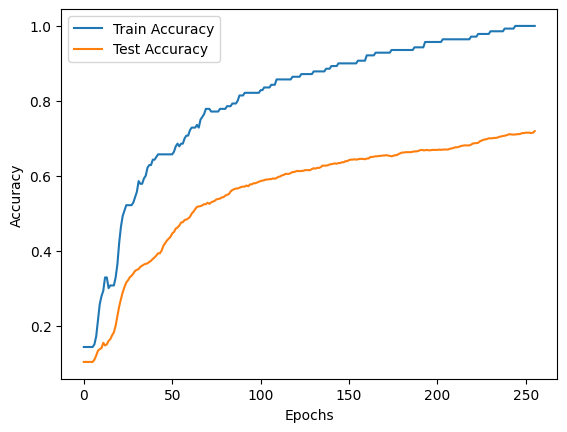

Final test accuracy: 0.719


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train(model, data, adj_matrix, params):
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])

    criterion = nn.CrossEntropyLoss()

    losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(params["num_epochs"]):
        optimizer.zero_grad()

        output = model(data.x, adj_matrix)

        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        _, predicted_train = output[data.train_mask].max(dim=1)
        correct_train = (predicted_train == data.y[data.train_mask]).sum().item()
        train_accuracy = correct_train / data.train_mask.sum().item()
        train_accuracies.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            output_test = model(data.x, adj_matrix)
            _, predicted_test = output_test[data.test_mask].max(dim=1)
            correct_test = (predicted_test == data.y[data.test_mask]).sum().item()
            test_accuracy = correct_test / data.test_mask.sum().item()
            test_accuracies.append(test_accuracy)
        model.train()  # Switch back to training mode

        if epoch % 8 == 0:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")

    return losses, train_accuracies, test_accuracies

train_losses, train_accuracies, test_accuracies = train(model, data, adj_matrix, params)

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("Final test accuracy:", test_accuracies[-1])


In [ ]:
# train_losses, train_accuracies, test_accuracies = train(model, data, adj_matrix, params)

# import matplotlib.pyplot as plt

# plt.plot(train_accuracies)
# plt.plot(test_accuracies)
# plt.show()

# print("Final test accuracy:", test_accuracies[-1])

## Part 2: Ablation Studies (Optional)

### 2.1: Importance of GNN and MLP modules
Add a parameter to the `CoraNodeClassification` class that allows you to select which modules to enable: only GNN, only MLP, or both. For example, your `forward` should look similarly to the following:

```python
def forward(self, x, adj_matrix):
    if self.gnn is not None:
      x = self.gnn(x, adj_matrix)
    
    if self.mlp is not None:
      x = self.mlp(x)

    return x
```

What is the impact of the two modules on the final result? Play a little around `hidden_features` and `num_layers` and briefly describe what you observe.

In [ ]:
# GNN only
model_gnn_only = CoraNodeClassification(
    num_features,
    params["hidden_features"],
    num_classes,
    gnn_layers=params["num_gcn_layers"],
    mlp_layers=params["num_mlp_layers"],
    enable_gnn=True,
    enable_mlp=False,
    gnn_act_fn=nn.ReLU,
    mlp_act_fn=nn.ReLU
).to(device)

# MLP only
model_mlp_only = CoraNodeClassification(
    num_features,
    params["hidden_features"],
    num_classes,
    gnn_layers=params["num_gcn_layers"],
    mlp_layers=params["num_mlp_layers"],
    enable_gnn=False,
    enable_mlp=True,
    gnn_act_fn=nn.ReLU,
    mlp_act_fn=nn.ReLU
).to(device)

# Both GNN and MLP
model_gnn_mlp = CoraNodeClassification(
    num_features,
    params["hidden_features"],
    num_classes,
    gnn_layers=params["num_gcn_layers"],
    mlp_layers=params["num_mlp_layers"],
    enable_gnn=True,
    enable_mlp=True,
    gnn_act_fn=nn.ReLU,
    mlp_act_fn=nn.ReLU
).to(device)


Epoch 000 | Loss: 3.9799 | Train Accuracy: 0.2643 | Test Accuracy: 0.1430
Epoch 008 | Loss: 3.9730 | Train Accuracy: 0.2714 | Test Accuracy: 0.1420
Epoch 016 | Loss: 3.9676 | Train Accuracy: 0.2786 | Test Accuracy: 0.1420
Epoch 024 | Loss: 3.9634 | Train Accuracy: 0.2786 | Test Accuracy: 0.1420
Epoch 032 | Loss: 3.9601 | Train Accuracy: 0.2857 | Test Accuracy: 0.1400
Epoch 040 | Loss: 3.9576 | Train Accuracy: 0.2857 | Test Accuracy: 0.1370
Epoch 048 | Loss: 3.9556 | Train Accuracy: 0.2857 | Test Accuracy: 0.1360
Epoch 056 | Loss: 3.9540 | Train Accuracy: 0.2786 | Test Accuracy: 0.1380
Epoch 064 | Loss: 3.9527 | Train Accuracy: 0.2786 | Test Accuracy: 0.1370
Epoch 072 | Loss: 3.9516 | Train Accuracy: 0.2643 | Test Accuracy: 0.1370
Epoch 080 | Loss: 3.9506 | Train Accuracy: 0.2571 | Test Accuracy: 0.1350
Epoch 088 | Loss: 3.9498 | Train Accuracy: 0.2643 | Test Accuracy: 0.1350
Epoch 096 | Loss: 3.9492 | Train Accuracy: 0.2643 | Test Accuracy: 0.1350
Epoch 104 | Loss: 3.9486 | Train Accur

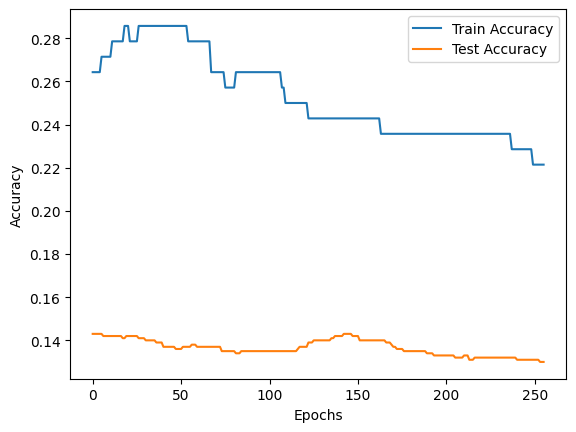

In [ ]:
train_losses, train_accuracies, test_accuracies = train(model_gnn_only, data, adj_matrix, params)

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 000 | Loss: 1.9490 | Train Accuracy: 0.1429 | Test Accuracy: 0.1030
Epoch 008 | Loss: 1.9240 | Train Accuracy: 0.1429 | Test Accuracy: 0.1030
Epoch 016 | Loss: 1.8997 | Train Accuracy: 0.1786 | Test Accuracy: 0.1040
Epoch 024 | Loss: 1.8751 | Train Accuracy: 0.2714 | Test Accuracy: 0.1040
Epoch 032 | Loss: 1.8496 | Train Accuracy: 0.4429 | Test Accuracy: 0.1110
Epoch 040 | Loss: 1.8223 | Train Accuracy: 0.6357 | Test Accuracy: 0.1230
Epoch 048 | Loss: 1.7930 | Train Accuracy: 0.7500 | Test Accuracy: 0.1470
Epoch 056 | Loss: 1.7612 | Train Accuracy: 0.8500 | Test Accuracy: 0.1750
Epoch 064 | Loss: 1.7266 | Train Accuracy: 0.8786 | Test Accuracy: 0.2170
Epoch 072 | Loss: 1.6891 | Train Accuracy: 0.9143 | Test Accuracy: 0.2710
Epoch 080 | Loss: 1.6486 | Train Accuracy: 0.9357 | Test Accuracy: 0.3150
Epoch 088 | Loss: 1.6053 | Train Accuracy: 0.9429 | Test Accuracy: 0.3560
Epoch 096 | Loss: 1.5592 | Train Accuracy: 0.9571 | Test Accuracy: 0.3890
Epoch 104 | Loss: 1.5109 | Train Accur

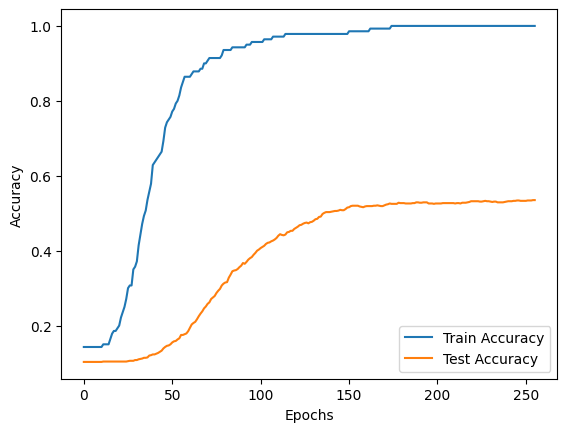

In [ ]:
train_losses, train_accuracies, test_accuracies = train(model_mlp_only, data, adj_matrix, params)

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 000 | Loss: 1.9493 | Train Accuracy: 0.1786 | Test Accuracy: 0.1620
Epoch 008 | Loss: 1.9280 | Train Accuracy: 0.2071 | Test Accuracy: 0.1900
Epoch 016 | Loss: 1.9113 | Train Accuracy: 0.3857 | Test Accuracy: 0.2480
Epoch 024 | Loss: 1.8935 | Train Accuracy: 0.4643 | Test Accuracy: 0.2960
Epoch 032 | Loss: 1.8730 | Train Accuracy: 0.5071 | Test Accuracy: 0.2990
Epoch 040 | Loss: 1.8492 | Train Accuracy: 0.5429 | Test Accuracy: 0.3030
Epoch 048 | Loss: 1.8220 | Train Accuracy: 0.5929 | Test Accuracy: 0.3310
Epoch 056 | Loss: 1.7892 | Train Accuracy: 0.6643 | Test Accuracy: 0.3860
Epoch 064 | Loss: 1.7515 | Train Accuracy: 0.7071 | Test Accuracy: 0.4230
Epoch 072 | Loss: 1.7080 | Train Accuracy: 0.7214 | Test Accuracy: 0.4570
Epoch 080 | Loss: 1.6584 | Train Accuracy: 0.7357 | Test Accuracy: 0.4850
Epoch 088 | Loss: 1.6033 | Train Accuracy: 0.7857 | Test Accuracy: 0.5270
Epoch 096 | Loss: 1.5417 | Train Accuracy: 0.8000 | Test Accuracy: 0.5550
Epoch 104 | Loss: 1.4757 | Train Accur

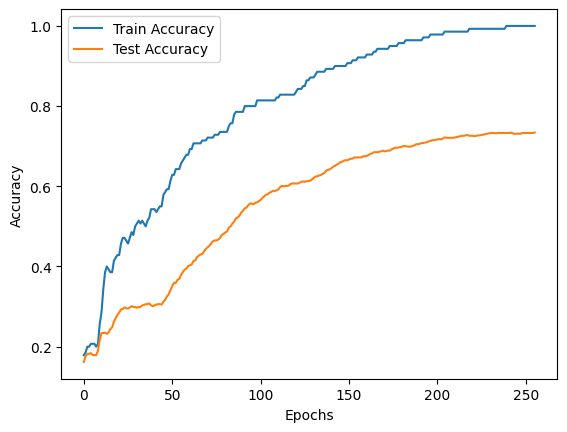

In [ ]:
train_losses, train_accuracies, test_accuracies = train(model_gnn_mlp, data, adj_matrix, params)

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

it performs poorly on the first one which is gnn only, but improves a bit with the mlp and is at its best when having both.

Epoch 000 | Loss: 1.9473 | Train Accuracy: 0.1500 | Test Accuracy: 0.1150
Epoch 008 | Loss: 1.8765 | Train Accuracy: 0.3500 | Test Accuracy: 0.2180
Epoch 016 | Loss: 1.7787 | Train Accuracy: 0.4286 | Test Accuracy: 0.2610
Epoch 024 | Loss: 1.5723 | Train Accuracy: 0.5429 | Test Accuracy: 0.3770
Epoch 032 | Loss: 1.2683 | Train Accuracy: 0.7214 | Test Accuracy: 0.5280
Epoch 040 | Loss: 0.8976 | Train Accuracy: 0.8571 | Test Accuracy: 0.6300
Epoch 048 | Loss: 0.5665 | Train Accuracy: 0.9286 | Test Accuracy: 0.7170
Epoch 056 | Loss: 0.3225 | Train Accuracy: 0.9571 | Test Accuracy: 0.7540
Epoch 064 | Loss: 0.1613 | Train Accuracy: 0.9929 | Test Accuracy: 0.7680
Epoch 072 | Loss: 0.0788 | Train Accuracy: 0.9929 | Test Accuracy: 0.7530
Epoch 080 | Loss: 0.0412 | Train Accuracy: 1.0000 | Test Accuracy: 0.7560
Epoch 088 | Loss: 0.0237 | Train Accuracy: 1.0000 | Test Accuracy: 0.7580
Epoch 096 | Loss: 0.0148 | Train Accuracy: 1.0000 | Test Accuracy: 0.7610
Epoch 104 | Loss: 0.0099 | Train Accur

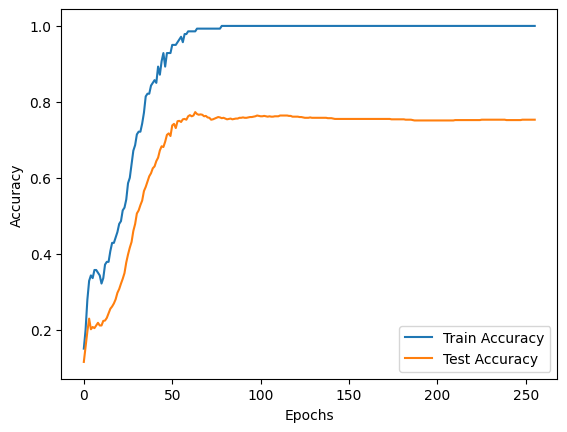

In [ ]:
params = {
    "hidden_features": 1024,
    "num_gcn_layers": 2,
    "num_mlp_layers": 3,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 256,
}

model_gnn_mlp = CoraNodeClassification(
    num_features,
    params["hidden_features"],
    num_classes,
    gnn_layers=params["num_gcn_layers"],
    mlp_layers=params["num_mlp_layers"],
    enable_gnn=True,
    enable_mlp=True,
    gnn_act_fn=nn.ReLU,
    mlp_act_fn=nn.ReLU
).to(device)


train_losses, train_accuracies, test_accuracies = train(model_gnn_mlp, data, adj_matrix, params)




plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 2.2: Importance of non-linearities
Try to replace all your activation functions with identities (or simply remove them). Do the results change? What does this tell you about this specific problem?

Epoch 000 | Loss: 1.9467 | Train Accuracy: 0.1429 | Test Accuracy: 0.1270
Epoch 008 | Loss: 1.8953 | Train Accuracy: 0.3429 | Test Accuracy: 0.2510
Epoch 016 | Loss: 1.8497 | Train Accuracy: 0.4643 | Test Accuracy: 0.3120
Epoch 024 | Loss: 1.7948 | Train Accuracy: 0.4929 | Test Accuracy: 0.3500
Epoch 032 | Loss: 1.7240 | Train Accuracy: 0.6071 | Test Accuracy: 0.4200
Epoch 040 | Loss: 1.6329 | Train Accuracy: 0.6643 | Test Accuracy: 0.4630
Epoch 048 | Loss: 1.5211 | Train Accuracy: 0.7286 | Test Accuracy: 0.5150
Epoch 056 | Loss: 1.3923 | Train Accuracy: 0.7429 | Test Accuracy: 0.5440
Epoch 064 | Loss: 1.2531 | Train Accuracy: 0.7857 | Test Accuracy: 0.5850
Epoch 072 | Loss: 1.1083 | Train Accuracy: 0.8143 | Test Accuracy: 0.6110
Epoch 080 | Loss: 0.9641 | Train Accuracy: 0.8714 | Test Accuracy: 0.6350
Epoch 088 | Loss: 0.8265 | Train Accuracy: 0.8929 | Test Accuracy: 0.6630
Epoch 096 | Loss: 0.7004 | Train Accuracy: 0.9143 | Test Accuracy: 0.6800
Epoch 104 | Loss: 0.5883 | Train Accur

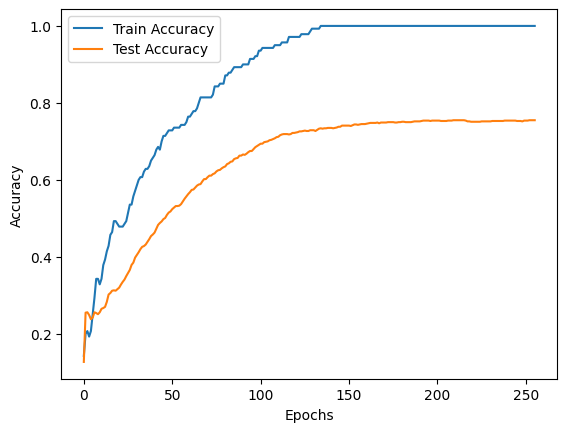

In [ ]:
params = {
    "hidden_features": 256,
    "num_gcn_layers": 2,
    "num_mlp_layers": 2,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 256,
}

model_gnn_mlp = CoraNodeClassification(
    num_features,
    params["hidden_features"],
    num_classes,
    gnn_layers=params["num_gcn_layers"],
    mlp_layers=params["num_mlp_layers"],
    enable_gnn=True,
    enable_mlp=True,
    gnn_act_fn=nn.Identity,
    mlp_act_fn=nn.Identity
).to(device)


train_losses, train_accuracies, test_accuracies = train(model_gnn_mlp, data, adj_matrix, params)


plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()